In [12]:
import flux_calc_parallel
import flux_variables
import thermalsyn_v2 as MQ24

import numpy as np
np.set_printoptions(legacy='1.25')
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import scipy.integrate as integrate
from scipy import special
import scipy as sc
import os

import Shell as Shell
import Constants as C
import time
import warnings

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({"text.latex.preamble": r"\usepackage{bm}","font.family": "serif", "font.serif": ["Computer Modern"],\
                     "text.usetex": True,})

In [13]:
'''
Fiducial Parameters
'''

p = 3.0
eps_e = 0.000001
eps_B = 0.1
eps_T = 0.4
n0 = 1e3
T = 50
mu_e = 1.18
mu_u = 0.62
d_L = 10**28
nu_res = 500
x_res = 30
phi_low = -1
phi_high = 6
z = 0
char_freq = 0
therm_el = False
pl_el = True
processes = 8
rtol = 1e-5

'''
Model Parameters and Output Arrays
'''

bg1 = 0.01
bg2 = 0.1
bg3 = 0.8
BG = np.array([bg1,bg2,bg3])

k = np.array([0,0,0])
alpha = np.array([0,0,0])

nu_low = np.array([1e1,1e1,1e-2])
nu_high = np.array([1e11,1e13,1e19])

FVars = ["F%d"% x for x in range(len(BG))]
F_thin = ["L%d"% x for x in range(len(BG))]
nu_theta = ["L%d"% x for x in range(len(BG))]
F_MQ24 = ["F%d"% x for x in range(len(BG))]
L_IHG = ["F%d"% x for x in range(len(BG))]
nu = ["F%d"% x for x in range(len(BG))]

x_left = ["F%d"% x for x in range(len(BG))]
x_right = ["F%d"% x for x in range(len(BG))]
y_left = ["F%d"% x for x in range(len(BG))]
y_right = ["F%d"% x for x in range(len(BG))]
center = ["F%d"% x for x in range(len(BG))]
R_l = ["F%d"% x for x in range(len(BG))]
X_perp = ["F%d"% x for x in range(len(BG))]
t_test = ["F%d"% x for x in range(len(BG))]
R_test = ["F%d"% x for x in range(len(BG))]
R0 = ["F%d"% x for x in range(len(BG))]
mu_max = ["F%d"% x for x in range(len(BG))]
y_min = ["F%d"% x for x in range(len(BG))]
R_EATS_interp_array = ["F%d"% x for x in range(len(BG))]
guess_r = ["F%d"% x for x in range(len(BG))]
L_hom = ["F%d"% x for x in range(len(BG))]

In [14]:
s = 1e5
a = 3.0
delta = 1.0

Lambda = (3*p+7+5*delta-a*(p+4))/(p+2+2*delta)   #Spectral slope in intermediate/transition region

In [15]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    for i in range(len(BG)):
        # R0[i],R_l[i],X_perp[i],mu_max[i],t_test[i],R_test[i],guess_r[i],y_min[i],x_left[i],y_left[i], x_right[i], y_right[i], center[i],\
                            # R_EATS_interp_array[i] = Shell.hydrodynamic_variables(alpha[i],T,BG[i],z)
        nu[i] = np.logspace(np.log10(nu_low[i]), np.log10(nu_high[i]),nu_res)   
        # nu_theta[i] = flux_variables.nu_theta_calc(1,1,eps_B,eps_T,R_l[i],X_perp[i],k[i],alpha[i],z,R0[i],t_test[i],R_test[i],BG[i],n0,\
                                                 # mu_e,mu_u,T,GRB_convention=False)

#Effective LOS approximation (R=R0)
        F_MQ24[i] = flux_variables.F_ELOS(T,n0,eps_e,eps_B,eps_T,p,mu_u,mu_e,BG[i],alpha[i],k[i],d_L,z,\
                                       nu_low[i],nu_high[i],nu_res,therm_el=therm_el)
        # (nu,s,a,delta,T,n0,eps_e,eps_B,eps_T,p,mu_u,mu_e,bG_sh0,alpha,k,d_L,z,therm_el=True,pl_el=True)
        L_IHG[i] = flux_variables.L_ELOS_IHG(nu[i],s,a,delta,T,n0,eps_e,eps_B,eps_T,p,mu_u,mu_e,BG[i],alpha[i],k[i],d_L,z,\
                                             therm_el=therm_el,pl_el=pl_el) 
        # L_IHG[i] = L_MQ24_IHG(nu[i],B1_over_B0,a,delta,T,n0,eps_e,eps_B,eps_T,p,mu_u,mu_e,BG[i],alpha[i],k[i],d_L,z,R0[i],\
        #                                R_l[i],X_perp[i],mu_max[i],t_test[i],R_test[i],guess_r[i],y_min[i],x_left[i],y_left[i],\
        #                                x_right[i], y_right[i],center[i],R_EATS_interp_array[i],nu_theta[i],therm_el=therm_el)

0.2499859383788462
0.0033834094756752856 0.016235378041382316 338.3409475675286 147.78140322498368 0.9997547624213067 0.9999592750374733 0.9998773791282564
0.2486024796197187
0.03384714596152686 0.16241640695811962 3384.714596152686 14.77244198279944 0.9997547624213062 0.9999592750374734 0.9998773791282558
0.1852349123916669
0.2765465943324795 1.3270159988981192 27654.65943324795 1.8080316671658823 0.9997547624213067 0.9999592750374734 0.9998773791282561


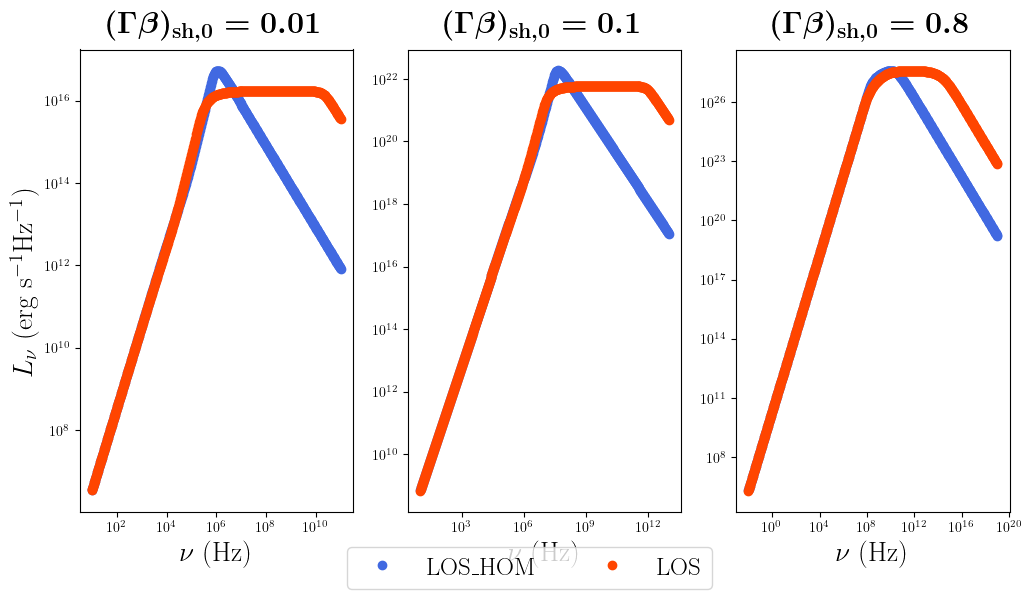

In [16]:
cols,rows = 3,1
fig, axes = plt.subplots(rows,cols,figsize=(12,6),sharex='col',sharey='col')
index = np.array([i for i in range(len(BG))])
index = index.reshape(rows,cols)

# for row in range(rows):
row = 0
for col in range(cols):
    ax = axes[col]
    n = index[0][col]
    start_time = time.time()

    if row==0 and col==0:
        # ax.loglog(nu[n], 4*np.pi*d_L**2*FVars[n], linestyle="",marker="o", markersize=8, color = 'orangered',\
              # label = 'Full Calculation', zorder = 2)
        ax.set_title(r'\boldmath$(\Gamma\beta)_{\rm sh,0} = '+str(BG[n])+'$',fontsize=22,y=1.02)

        # ax.loglog(nu[n], 4*np.pi*d_L**2*F_thin[n], color = 'black',linestyle='--',linewidth=2.0, label = 'Thin Shell')
        ax.loglog(nu[n], 4*np.pi*d_L**2*F_MQ24[n], color = 'royalblue',linestyle='',marker="o",linewidth=2.0, label = "LOS_HOM")
        ax.loglog(nu[n], L_IHG[n], color = 'orangered',linestyle='',marker="o",linewidth=2.0, label = "LOS")

    else:
        # ax.loglog(nu[n], 4*np.pi*d_L**2*FVars[n], linestyle="",marker="o", markersize=8, color = 'orangered',\
                  # zorder = 2)
        if row==0:
            ax.set_title(r'\boldmath$(\Gamma\beta)_{\rm sh,0} = '+str(BG[n])+'$',fontsize=22,y=1.02)

        # if row==1 and col==0:
        #     ax.loglog(nu[n], 4*np.pi*d_L**2*FVars[col],linestyle='dotted',color = 'slategray',\
            #           label = r'k = ' + str(round(k[col],2))+r', $\alpha$ = '+str(round(alpha[col],2)),\
            #           linewidth=2.0)                     
            # if row!=0:
            #     ax.loglog(nu[n], 4*np.pi*d_L**2*FVars[col],linestyle='dotted',color = 'slategray',\
            #                                     linewidth=2.0)

        ax.loglog(nu[n], 4*np.pi*d_L**2*F_MQ24[n], color = 'royalblue',linestyle='',marker="o",linewidth=2.0)
        ax.loglog(nu[n], L_IHG[n], color = 'orangered',linestyle='',marker="o",linewidth=2.0)

    if row==0:
        ax.set_xlabel(r"$\nu$ (Hz)",fontsize=20)
    if col==0:
        ax.set_ylabel(r"$L_\nu$ (\rm erg $\rm s^{-1} Hz^{-1})$",fontsize=20)

fig.legend(loc='lower center',bbox_to_anchor=(0.5, -0.04),ncol=4,fontsize=18)
# fig.savefig(os.getcwd()+"/Fig3.pdf",bbox_inches='tight')
plt.show()

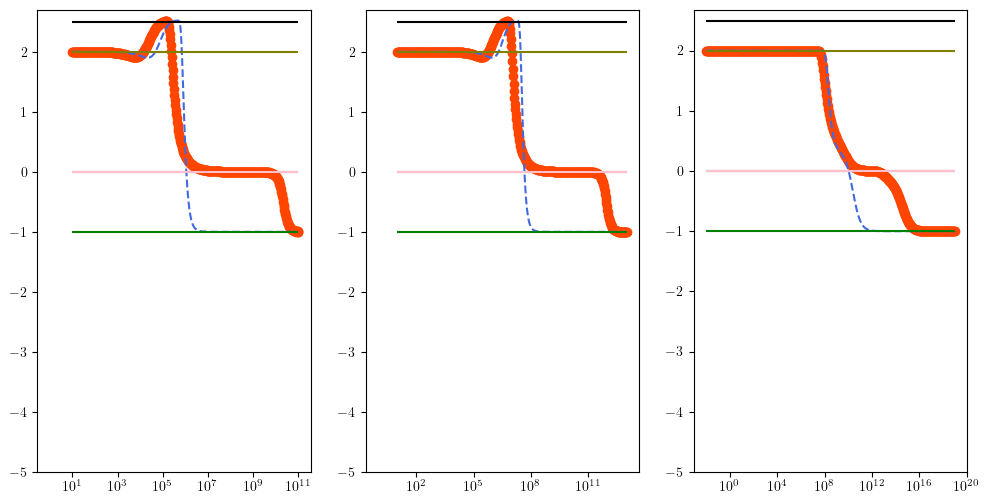

In [19]:
cols, rows = 3,1
fig, axes = plt.subplots(rows,cols,figsize=(12,6),sharex='col',sharey='col')
index = np.array([i for i in range(len(BG))])
index = index.reshape(rows,cols)

# for row in range(rows):
row = 0
for col in range(cols):
    ax = axes[col]
    i = index[0][col]
    

    logphi, log_diff = flux_variables.dlnF_dlnnu(L_IHG[i], nu[i])
    ax.semilogx(nu[i], log_diff,linestyle='',marker='o',color='orangered')
    
    logphi, log_diff = flux_variables.dlnF_dlnnu(F_MQ24[i], nu[i])
    ax.semilogx(nu[i], log_diff,linestyle='dashed',color='royalblue')
    
    ax.hlines(2.0,nu_low[i],nu_high[i],'olive')
    ax.hlines(0,nu_low[i],nu_high[i],'indigo')
    ax.hlines(2.5,nu_low[i],nu_high[i],color='black')
    ax.hlines(-1.0,nu_low[i],nu_high[i],color='green')
    ax.hlines(Lambda,nu_low[i],nu_high[i],color='pink')
    ax.set_ylim(-5)
plt.show()